In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
n_samples = 100
time_step = torch.cat((torch.linspace(0,5,int(n_samples/2)), torch.linspace(7,10,int(n_samples/2))))
travel_times = 10 + torch.randn(n_samples)

train_x = time_step
train_y = travel_times

# train_x = torch.linspace(0, 1, 100)
# variance = 0.04
# sigma = math.sqrt(variance)
# train_y = torch.sin(train_x * (2 * math.pi)) + sigma * torch.randn(train_x.size())

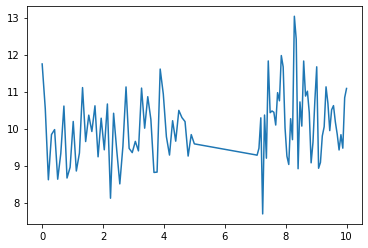

In [4]:
plt.plot(train_x, train_y)

In [5]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 5.463   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 4.918   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 4.459   lengthscale: 0.798   noise: 0.797
Iter 4/50 - Loss: 4.074   lengthscale: 0.853   noise: 0.851
Iter 5/50 - Loss: 3.751   lengthscale: 0.909   noise: 0.906
Iter 6/50 - Loss: 3.480   lengthscale: 0.966   noise: 0.959
Iter 7/50 - Loss: 3.251   lengthscale: 1.024   noise: 1.010
Iter 8/50 - Loss: 3.058   lengthscale: 1.082   noise: 1.059
Iter 9/50 - Loss: 2.895   lengthscale: 1.140   noise: 1.104
Iter 10/50 - Loss: 2.755   lengthscale: 1.198   noise: 1.145
Iter 11/50 - Loss: 2.636   lengthscale: 1.255   noise: 1.181
Iter 12/50 - Loss: 2.533   lengthscale: 1.311   noise: 1.211
Iter 13/50 - Loss: 2.443   lengthscale: 1.367   noise: 1.236
Iter 14/50 - Loss: 2.365   lengthscale: 1.421   noise: 1.256
Iter 15/50 - Loss: 2.297   lengthscale: 1.474   noise: 1.270
Iter 16/50 - Loss: 2.237   lengthscale: 1.525   noise: 1.279
Iter 17/50 - Loss: 2.183   length

In [10]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 51)
    observed_pred = likelihood(model(test_x))

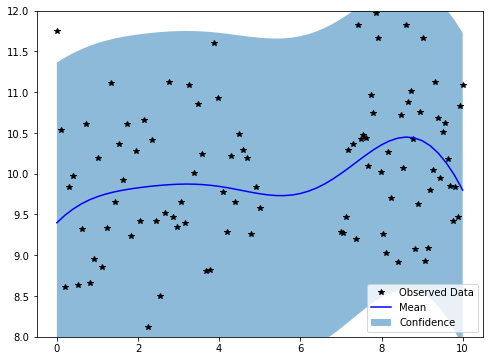

In [11]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([8, 12])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
n_samples = 100
time_step = torch.cat((torch.linspace(0,5,int(n_samples/2)), torch.linspace(7,10,int(n_samples/2))))
travel_times = 10 + torch.randn(n_samples)

In [ ]:
plt.plot(time_step, travel_times, 'k*')